# Heart Data machine Learning
Machine learning using refined data from Heart_data_analysis.ipynb <br>
This notebook will be heavly based on https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets <br>
## Setup

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# #imlearn tools
# from imblearn.under_sampling import NearMiss
# from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
#misc
import warnings
from collections import Counter

warnings.filterwarnings("ignore")


df=pd.read_csv('Data/heart_refined.csv')

In [49]:
df.head(5)

,Unnamed: 0,sex,cp,fbs,restecg,exang,oldpeak,slope,ca,thal,target,scaled_age,scaled_trestbps,scaled_thalach,scaled_chol
0,0,1,3,1,0,0,2.3,0,0,1,1,0.592593,0.75,-0.092308,-0.110236
1,1,1,2,0,1,0,3.5,0,0,2,1,-1.333333,0.00,1.046154,0.157480
2,2,0,1,0,0,0,1.4,2,0,2,1,-1.037037,0.00,0.584615,-0.566929
3,3,1,1,0,1,0,0.8,2,0,2,1,0.074074,-0.50,0.769231,-0.062992
4,4,0,0,0,1,1,0.6,2,0,2,1,0.148148,-0.50,0.307692,1.795276


## Preparing data for machine learning

In [50]:
X = df.drop('target', axis=1)
y = df['target']
# separating test data from train data to reduce bias
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [52]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [53]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 99.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 100.0 % accuracy score
Classifiers:  SVC Has a training score of 99.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 100.0 % accuracy score


## Grid search to find better parameters

In [54]:

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_
#------------------------------------------------#
# kneighbors
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

knears_neighbors = grid_knears.best_estimator_
#-----------------------------------------------#
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

svc = grid_svc.best_estimator_
#----------------------------------------------#
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

tree_clf = grid_tree.best_estimator_

In [55]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  99.55%
Knears Neighbors Cross Validation Score 99.55%
Support Vector Classifier Cross Validation Score 99.55%
DecisionTree Classifier Cross Validation Score 99.55%


## Plotting learning curves

In [56]:


def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\rlgava\\Documents\\Mestrado\\Python\\Nana_Project\\nana_amb\\lib\\site-packages\\matplotlib\\pyplot.py'>

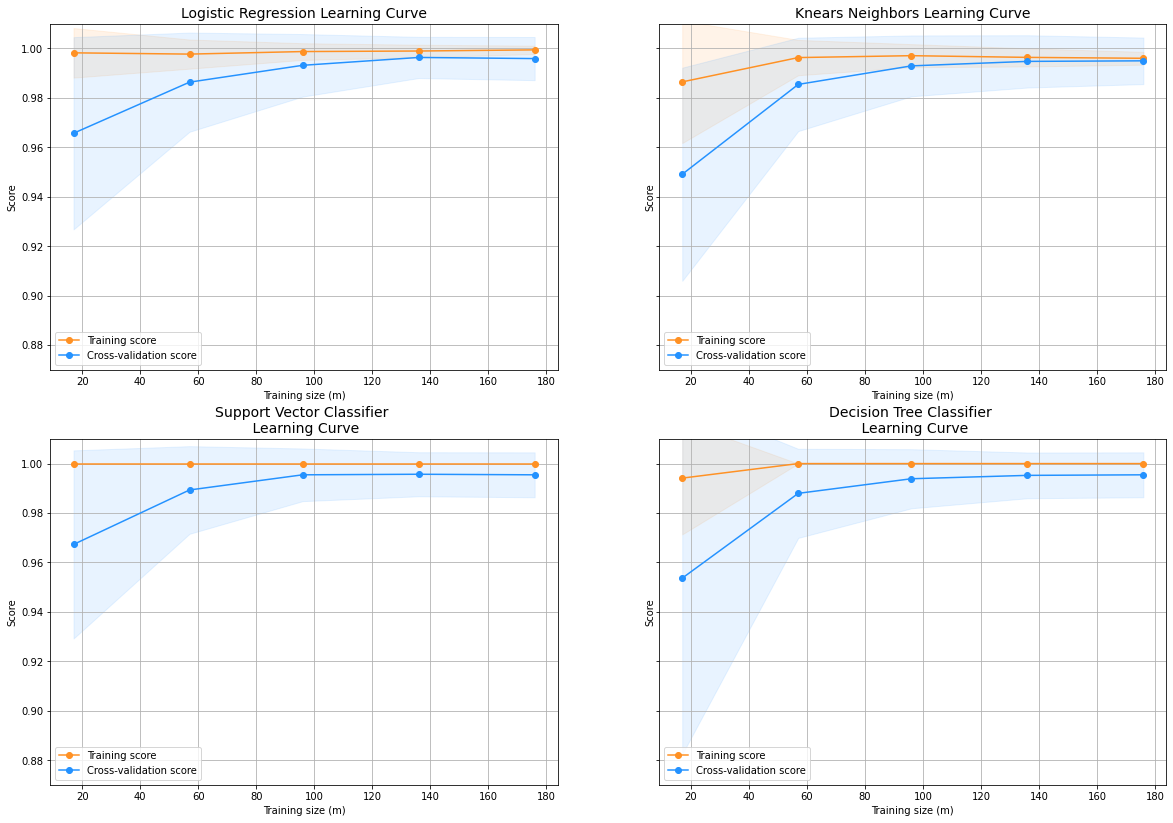

In [57]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [58]:

# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)



In [59]:

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))


Logistic Regression:  0.9999157894736842
KNears Neighbors:  0.996
Support Vector Classifier:  1.0
Decision Tree Classifier:  0.996


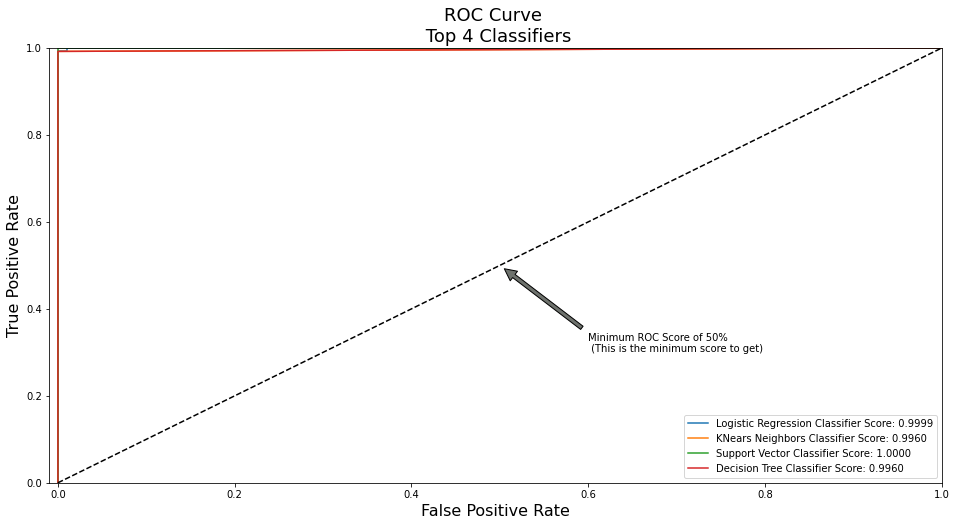

In [60]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()